In [1]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
cifar_folder = 'data/cifar-10-batches-py'

labels_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 
    'frog', 'horse', 'ship', 'truck']
label_count = len(labels_names)
print(labels_names)

def load_cifar_batch(folder, file):
    with open(os.path.join(folder, file), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    print(dict[b'batch_label'])
    return dict[b'data'], np.array(dict[b'labels'])

def load_cifar(folder):
    x_tr = list()
    y_tr = list()
    for i in range(1, 6):
        x, y = load_cifar_batch(folder, 'data_batch_' + str(i))
        x_tr.append(x)
        y_tr.append(y)
    x_tr = np.concatenate(x_tr)
    y_tr = np.concatenate(y_tr)
    x_te, y_te = load_cifar_batch(folder, 'test_batch')
    return x_tr, y_tr, x_te, y_te

x_tr, y_tr, x_te, y_te = load_cifar(cifar_folder)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'
(50000, 3072) (50000,) (10000, 3072) (10000,)


In [4]:
def plot_image(x, y):
    plt.imshow(x.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
    plt.title(labels_names[y])
    plt.axis('off')

def show_image(x, y):
    plot_image(x, y)
    plt.show()

def show_images(xs, ys):
    n = len(xs)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plot_image(xs[i], ys[i])
    plt.show()

def show_train_images(pos):
    show_images(x_tr[pos:pos+5], y_tr[pos:pos+5])

silence = interact(show_train_images, 
        pos=widgets.BoundedIntText(min=0, max=49999, step=5, value=0, description='Range start:'))

A Jupyter Widget

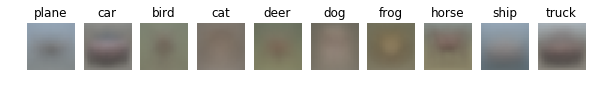

In [5]:
y_mean = range(10)
x_mean = [x_tr[y_tr == y].mean(axis=0) for y in y_mean]
show_images(x_mean, y_mean)

In [6]:
# Perform one hot encoding
y_tr_n = np.eye(label_count)[y_tr]
y_te_n = np.eye(label_count)[y_te]

print(y_tr_n.shape)
print(y_te_n.shape)

x_tr_n = x_tr / 1.0
x_te_n = x_te / 1.0

(50000, 10)
(10000, 10)


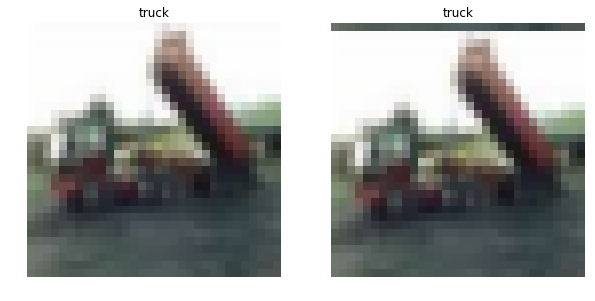

In [23]:
def flip_images(x):
    result = x.reshape(-1, 3, 32, 32)
    result = result.transpose(0, 2, 3, 1)
    print(result.shape)
    result = np.flip(result, axis=2)
    result = result.transpose(0, 3, 1, 2)
    result = result.reshape(-1, 3 * 32 * 32)
    return result

def shift_images(x, shift, axis):
    y = x.reshape(-1, 3, 32, 32)
    y = np.roll(y, shift, axis=axis)
    return y.reshape(-1, 3 * 32 * 32)

x_tr_m = shift_images(x_tr, 1, 2)
x_te_m = shift_images(x_te, 1, 2)
show_images([x_tr[2], x_tr_m[2]], [y_tr[2], y_tr[2]])

In [75]:
np.random.seed(5)
W = np.random.rand(x_tr_n.shape[1], label_count) * 0.001
B = np.random.rand(label_count) * 0.001

print(W.shape)
print(B.shape)

(3072, 10)
(10,)


In [84]:
speed = 0.1

def predict(x_n, x_m):
    global W
    global B
    W1_in = x_n
    W1_out = np.dot(W1_in, W)
    W2_in = x_m
    W2_out = np.dot(W2_in, W)
    P1 = np.array(W1_out > W2_out, dtype='float')
    P2 = np.array(W2_out > W1_out, dtype='float')
    B_in = np.maximum(W1_out, W2_out)
    B_out = B_in + B
    y_pred = B_out
    return y_pred

def calculate_accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))

def calculate_loss(y_pred, y):
    value_of_true = np.sum(y_pred * y, axis=1)
    result = y_pred + 1 - value_of_true.reshape(-1, 1)
    result = np.maximum(result, 0)
    result[np.arange(result.shape[0]), np.argmax(y, axis=1)] = 0
    return np.mean(result)

def calculate_grad(y_pred, y):
    result = np.sum(y_pred * y, axis=1)
    result = y_pred - y + 1 - result.reshape(-1, 1)
    result = np.maximum(result, 0)
    result[result > 0.00001] = 1
    result[np.arange(result.shape[0]), np.argmax(y, axis=1)] = -np.sum(result, axis=1)
    result = result / y.shape[0]
    return result

def calculate_reg_grad():
    n = len(W)
    W_shifted = W.reshape(n)

def perform_step():
    global x_tr_n
    global y_tr_n
    global W
    global B
    W1_in = x_tr_n
    W1_out = np.dot(W1_in, W)
    W2_in = x_tr_m
    W2_out = np.dot(W2_in, W)
    P1 = np.array(W1_out > W2_out, dtype='float')
    P2 = np.array(W2_out > W1_out, dtype='float')
    B_in = np.maximum(W1_out, W2_out)
    B_out = B_in + B
    y_pred = B_out
    
    print('  current loss:', calculate_loss(y_pred, y_tr_n))

    grad = calculate_grad(y_pred, y_tr_n)
    
    B = B - speed * np.sum(grad, axis=0)
    W = W - speed * np.dot(W1_in.transpose(), grad*P1)
    W = W - speed * np.dot(W2_in.transpose(), grad*P2)
    #W_dif_1 = W - np.roll(W, 1, axis=0)
    #W_dif_2 = W - np.roll(W, 32, axis=0)
    #W_dif_3 = W - np.roll(W, 32 * 32, axis=0)
    #W = W - speed * W_dif_1 # * np.abs(W_dif)
    #W = W - speed * W_dif_2 # * np.abs(W_dif)
    #W = W - speed * W_dif_3 # * np.abs(W_dif)
    W = W - speed * W # * np.abs(W)
    B = B - speed * B # * np.abs(B)

output = widgets.Output()
output.layout.height = '110px'
display(output)
    
loss_before = calculate_loss(predict(x_tr_n, x_tr_m), y_tr_n)
print('Loss before:', loss_before)

speed = 0.0001

for i in range(10):
    perform_step()
    if i < 10 or i % 5 == 0:
    #if i % 10 == 0:
        images = W.transpose()*500 + 128
        images = np.minimum(255, np.maximum(0, images))
        output.clear_output()
        with(output):
            show_images(images, range(10))

loss_after = calculate_loss(predict(x_tr_n, x_tr_m), y_tr_n)
print('Loss after:', loss_after)

print('Loss change:', loss_after - loss_before)

print('Accuracy tr:', calculate_accuracy(predict(x_tr_n, x_tr_m), y_tr_n))
print('Accuracy te:', calculate_accuracy(predict(x_te_n, x_te_m), y_te_n))

A Jupyter Widget

Loss before: 3407.26875251
  current loss: 3407.26875251
  current loss: 2789.01820022
  current loss: 2273.84963672
  current loss: 1864.57585173
  current loss: 1564.22233399
  current loss: 1369.51167087
  current loss: 1265.63952387
  current loss: 1220.56069802
  current loss: 1202.7575902
  current loss: 1195.09367613
Loss after: 1190.57688155
Loss change: -2216.69187097
Accuracy tr: 0.3572
Accuracy te: 0.3535


In [63]:
images = W.transpose()*500 + 128
images = np.minimum(255, np.maximum(0, images))

def show_image_w(index):
    show_image(images[index], index)

interact(show_image_w, index=widgets.BoundedIntText(min=0, max=9, step=1, value=0))

A Jupyter Widget

<function __main__.show_image_w>